In [94]:
import pandas as pd 
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [49]:
def get_dados(path = "dados//dados.xlsx", tipo_target = "num"):
    variaveis = pd.read_excel(path, sheet_name = "Dados Bons")
    variaveis.set_index("Data", inplace = True)
    variaveis.drop(index = pd.to_datetime("2000-01-01"), inplace = True)
    
    spy_ohlc_df = yf.download('SPY', start = '2000-01-01', interval = "3mo")
    spy_ohlc_df.dropna(inplace = True)
    spy_ohlc_df["Target"] = spy_ohlc_df["Adj Close"].pct_change(1)
    spy_ohlc_df = spy_ohlc_df["Target"]
    variaveis = variaveis.join(spy_ohlc_df)
    
    if tipo_target == "cat":
        target = variaveis["Target"] > 0
        variaveis["Retorno"] = variaveis["Target"]
        variaveis.drop("Target", axis = 1, inplace = True)
        variaveis["Target"] = target
    
    return variaveis
    
df = get_dados(tipo_target = "cat")

[*********************100%***********************]  1 of 1 completed


In [50]:
df.head()

,T-BOND,GDP Real,Real PCE,M1,Real Disposable,Personal Savings,Exports,Imports,Labor Productivity,NFIB Small Business Optimism,Industrial Production,CPI,Retorno,Target
Data,,,,,,,,,,,,,,
2000-04-01,-0.046811,0.0182,0.0068,-0.0016,-0.0026,0.0595,0.0516,0.0737,0.6667,0.0233,0.0139,0.0896,-0.031419,False
2000-07-01,-0.045872,0.0010,0.0069,-0.0126,0.0218,0.0572,0.0189,0.0570,-0.2500,-0.0227,0.0007,-0.8740,-0.009072,False
2000-10-01,-0.055430,0.0059,0.0061,0.0030,-0.0166,-0.0547,0.0097,-0.0091,-0.1667,-0.0466,-0.0025,-3.1400,-0.084302,False
2001-01-01,-0.092814,-0.0032,0.0013,0.0016,0.0235,0.1172,-0.0414,-0.0616,-0.0400,0.0977,-0.0157,-2.2702,-0.107781,False
2001-04-01,0.043564,0.0062,-0.0004,0.0201,0.0081,-0.0781,-0.0220,-0.0082,-0.0833,0.0142,-0.0135,2.0418,0.053475,True


# REGRESSÃO LOGÍSTICA

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [81]:
x = df.drop(["Target", "Retorno"], axis = 1)
y = df["Target"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.5, shuffle = False)

In [83]:
modelo = LogisticRegression()
modelo.fit(x_train, y_train)
y_pred_train = modelo.predict(x_train)
y_pred_test = modelo.predict(x_test)
print("R2: ",modelo.score(x_train, y_train))

resultados = pd.DataFrame({"Previsto" : y_pred_test, "Observado" : y_test})

R2:  0.5853658536585366


In [87]:
print("Avaliando a base de treinamento:")
print(confusion_matrix(y_train, y_pred_train))
print("\n")
# Avaliando a base de teste
print("Avaliando a base de test:")
print(confusion_matrix(y_test, y_pred_test))

Avaliando a base de treinamento:
[[ 2 16]
 [ 1 22]]


Avaliando a base de test:
[[ 0  8]
 [ 3 30]]


In [88]:
# Calculando a ROC e o Gini - Treinamento
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train)
roc_auc_train = auc(fpr_train, tpr_train)

print("AUC - Treinamento : %f" % roc_auc_train)
print("Gini - Treinamento: ", round(2*roc_auc_train-1,2))
print("\n")

# Calculando a ROC e o Gini - Teste
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test)
roc_auc_test = auc(fpr_test, tpr_test)

print("AUC - Teste : %f" % roc_auc_test)
print("Gini - Teste: ", round(2*roc_auc_test-1,2))

AUC - Treinamento : 0.533816
Gini - Treinamento:  0.07


AUC - Teste : 0.454545
Gini - Teste:  -0.09


### Plot ROC

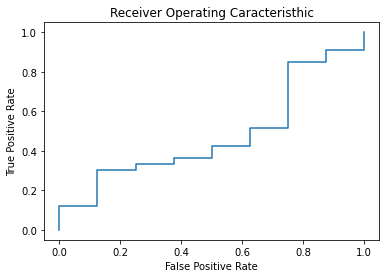

In [97]:
#define metrics
y_pred_proba = modelo.predict_proba(x_test)[::,1] # Probabilidade de Y = 1 
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC - Receiver operating characteristic")
plt.show()

# Backtest

In [80]:
x = df.drop("Target", axis = 1)
y = df["Target"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.5, shuffle = False)

In [78]:
retorno = []
for i in range(len(resultados["Previsto"])):
    if resultados["Previsto"][i] == True:
        retorno.append(x["Retorno"][i])
    else:
        retorno.append(-x["Retorno"][i])

resultados["Retorno"] = retorno
resultados["Ret Acumulado"] = np.cumprod(1 + np.array(retorno))
resultados["Retorno_BH_acum"] = np.cumprod(1 + x["Retorno"])
resultados.head()

,Previsto,Observado,Retorno,Ret Acumulado,Retorno_BH,Retorno_BH_acum
Data,,,,,,
2010-07-01,True,True,-0.031419,0.968581,0.110958,0.911984
2010-10-01,True,True,-0.009072,0.959794,0.107712,1.010216
2011-01-01,True,True,-0.084302,0.878881,0.059939,1.070767
2011-04-01,True,False,-0.107781,0.784154,-0.000352,1.070390
2011-07-01,True,False,0.053475,0.826087,-0.138357,0.922293


<AxesSubplot:xlabel='Data'>

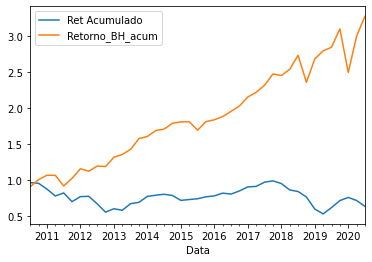

In [79]:
resultados[["Ret Acumulado", "Retorno_BH_acum"]].plot()